# Data Generation Tutorial: Data-Free (Zero-Shot) Quantization in Pytorch with the Model Compression Toolkit (MCT)
[Run this tutorial in Google Colab](https://colab.research.google.com/github/sony/model_optimization/blob/main/tutorials/notebooks/mct_features_notebooks/pytorch/example_pytorch_data_generation.ipynb)

## Overview
In this tutorial, we will explore how to generate synthetic images using the Model Compression Toolkit (MCT) and the Data Generation Library. These generated images are based on the statistics stored in the model's batch normalization layers and can be usefull for various compression tasks, such as quantization and pruning. We will use the generated images as a representative dataset to quantize our model to 8-bit using MCT's Post Training Quantization (PTQ).

## Summary
We will cover the following steps:
1. **Setup** Install and import necessary libraries and load a pre-trained model.
2. **Configuration**: Define the data generation configuration.
3. **Data Generation**: Generate synthetic images.
4. **Visualization**: Visualize the generated images.
5. **Quantization**: Quantize our model to 8-bit using PTQ with the generated images as a representative dataset. This is called **"Data-Free Quantization"** since no real data is used in the quantization process.

## Step 1: Setup
Install the necessary packages:

In [1]:
!pip install -q torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.4 MB/s eta 0:00:00


In [2]:
import importlib
if not importlib.util.find_spec('model_compression_toolkit'):
    !pip install model_compression_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.7/962.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.6
    Uninstalling pydantic-2.10.6:
      Successfully uninstalled pydantic-2.10.6
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 

In [4]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

Load the model from the torchvision library:

In [7]:
# Load a pre-trained model (e.g., ResNet18)
weights = ResNet18_Weights.DEFAULT
float_model = resnet18(weights=weights)

## Step 2: Define a Data Generation Configuration
Next, we need to specify the configuration for data generation using `get_pytorch_data_generation_config`. This configuration includes parameters such as the number of iterations, optimizer, batch size, and more. Customize these parameters according to your needs.

In [5]:
import model_compression_toolkit as mct

data_gen_config = mct.data_generation.get_pytorch_data_generation_config(
    n_iter=500,                      # Number of iterations
    optimizer=torch.optim.RAdam,     # Optimizer
    data_gen_batch_size=128,          # Batch size for data generation
    initial_lr=16,                   # Initial learning rate
    output_loss_multiplier=1e-6,     # Multiplier for output loss
    extra_pixels=32,
    # ... (customize other parameters)
)

## Step 3: Generate Synthetic Images

Now, let's generate synthetic images using the `pytorch_data_generation_experimental` function. Specify the number of images you want to generate and the output image size.

In [9]:
n_images = 128              # Number of images to generate
output_image_size = 128     # Size of output images

generated_images = mct.data_generation.pytorch_data_generation_experimental(
    model=float_model,
    n_images=n_images,
    output_image_size=output_image_size,
    data_generation_config=data_gen_config
)

pytorch_data_generation_experimental is experimental and is subject to future changes.If you encounter an issue, please open an issue in our GitHub project https://github.com/sony/model_optimization


/usr/local/lib/python3.11/dist-packages/model_compression_toolkit/data_generation/pytorch/optimization_utils.py:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/model_compression_toolkit/data_generation/pytorch/pytorch_data_generation.py:320: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/model_compression_toolkit/data_g

Total time to generate 128 images (seconds): 7898
Final Loss: Total 0.0019480162300169468, BN loss 0.0019687076564878225, Output loss -20.69139862060547


## Step 4: Visualization
Lets define a function to display the generated images:

In [19]:
def plot_image(image, reverse_preprocess=False, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.detach().cpu().numpy()[0]
    image = image.transpose(1, 2, 0)
    if reverse_preprocess:
        new_image = np.round(((image.astype(np.float32) * std) + mean) * 255).astype(np.uint8)
    plt.imshow(new_image)
    plt.show()

Now, let's visualize the generated images by selecting an image index to plot. You can modify the index values to experiment with different images.

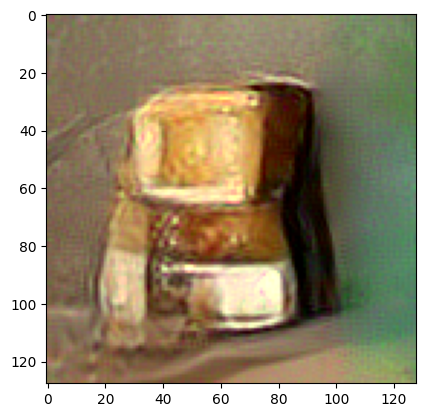

In [11]:
img_index_to_plot = 0
plot_image(generated_images[img_index_to_plot],True)

## Step 5: Post Training Quantization
In order to evaulate our generated images, we will use them to quantize the model using MCT's PTQ.This is referred to as **"Zero-Shot Quantization (ZSQ)"** or **"Data-Free Quantization"** because no real data is used in the quantization process. Next we will define configurations for MCT's PTQ.

### Target Platform Capabilities (TPC)
MCT optimizes the model for dedicated hardware platforms. This is done using TPC (for more details, please visit our [documentation](https://sony.github.io/model_optimization/api/api_docs/modules/target_platform_capabilities.html)). Here, we use the default Pytorch TPC:

In [12]:
target_platform_cap = mct.get_target_platform_capabilities("pytorch", "default")

### Representative Dataset
For quantization with MCT, we need to define a representative dataset required by the PTQ algorithm. This dataset is a generator that returns a list of images. We wil use our generated images for the representative dataset.

In [13]:
batch_size = 64
n_iter = 10

generated_images = np.concatenate(generated_images, axis=0).reshape(*(-1, batch_size, *list(generated_images[0].shape[1:])))

def representative_data_gen():
    for nn in range(n_iter):
        nn_mod = nn % generated_images.shape[0]
        yield [generated_images[nn_mod]]

### Quantization with our generated images
Now, we are ready to use MCT to quantize the model.

In [14]:
# run post training quantization on the model to get the quantized model output
quantized_model_generated_data, quantization_info = mct.ptq.pytorch_post_training_quantization(
    in_module=float_model,
    representative_data_gen=representative_data_gen,
    target_platform_capabilities=target_platform_cap
)

DepthwiseConv2D is not in model.


Statistics Collection: 10it [00:37,  3.77s/it]



Running quantization parameters search. This process might take some time, depending on the model size and the selected quantization methods.



Calculating quantization parameters: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]



Please run your accuracy evaluation on the exported quantized model to verify it's accuracy.
Checkout the FAQ and Troubleshooting pages for resolving common issues and improving the quantized model accuracy:
FAQ: https://github.com/sony/model_optimization/tree/main/FAQ.md
Quantization Troubleshooting: https://github.com/sony/model_optimization/tree/main/quantization_troubleshooting.md


## Setup for evaluation on the ImageNet dataset
### Download ImageNet validation set
Download ImageNet dataset with only the validation split. This step may take several minutes...

In [15]:
import os

if not os.path.isdir('imagenet'):
    !mkdir imagenet
    !wget -P imagenet https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz
    !wget -P imagenet https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar

# Extract ImageNet validation dataset using torchvision "datasets" module.
dataset = ImageNet(root='./imagenet', split='val', transform=weights.transforms())
val_dataloader = DataLoader(dataset, batch_size=50, shuffle=False, num_workers=16, pin_memory=True)

--2025-02-23 15:38:27--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2568145 (2.4M) [application/x-gzip]
Saving to: ‘imagenet/ILSVRC2012_devkit_t12.tar.gz’

ILSVRC2012_devkit_t 100%[===================>]   2.45M   487KB/s    in 5.2s    

2025-02-23 15:38:33 (480 KB/s) - ‘imagenet/ILSVRC2012_devkit_t12.tar.gz’ saved [2568145/2568145]

--2025-02-23 15:38:33--  https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6744924160 (6.3G) [application/x-tar]
Saving to: ‘imagenet/ILSVRC2012_img_val.tar’

ILSVRC2012_img_val. 100%[===================>]   6.28G  7.02MB/s    in 10m 59s 

2025-02-23 15:

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Here we define functions for evaluation:

In [16]:
from tqdm import tqdm


def evaluate(model, testloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # correct += (predicted == labels).sum().item()
    val_acc = (100 * correct / total)
    print('Accuracy: %.2f%%' % val_acc)
    return val_acc

### Evaluation of the quantized model's performance
Here we evaluate our model's top 1 classification performance after PTQ on the ImageNet validation dataset.
Let's start with the floating-point model evaluation.

In [17]:
evaluate(float_model, val_dataloader)

100%|██████████| 1000/1000 [1:20:19<00:00,  4.82s/it]

Accuracy: 69.76%


69.76

Finally, let's evaluate the quantized model:

In [18]:
evaluate(quantized_model_generated_data, val_dataloader)

100%|██████████| 1000/1000 [1:59:51<00:00,  7.19s/it]

Accuracy: 69.53%


69.532

## Conclusion:
In this tutorial, we demonstrated how to generate synthetic images from a trained model and use them for model quantization. The quantized model achieved a 4x reduction in size compared to the original float model, while maintaining performance similar to the reported float results. Notably, no real data was required in this process.

## Copyrights:
Copyright 2023 Sony Semiconductor Israel, Inc. All rights reserved.
Licensed under the Apache License, Version 2.0 (the “License”); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an “AS IS” BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.